# Validating solver code

This notebook is part of the code for my (Elvis Sikora) bachelor thesis.

We will compute the drag coefficient and Strouhal number of 2D low-Reynolds flow around a circular cylinder.
The goal here is to try to validate the OpenFOAM code I am using to solve cases
that are fed to a neural network.

In [41]:
# should we skip solving cases (which is very time-consuming)?
# useful for multiple runs of this file
SKIP_SOLVING = False

### Importing needed external libraries

First of all, activate the `autoreload` magic so that if I make any changes to the
code in external files, they are automatically reloaded here.

In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importing standard libraries:

In [43]:
from pathlib import Path
from os import chdir

Importing external libraries

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as signal

Now importing my own code 

In [45]:
import solver.cloud_array as ca
from solver.cloud_array import load_forces, CloudArray
from solve_cases import solve_cases
import solver.validation as val
from train import Dataset

### Setting up the directories

Let's get into the correct directory, the `solver` subdir under the repo's base.

In [46]:
if Path('.').resolve().name != 'solver':
    chdir('solver')
assert Path('./validation.py').exists()

If there are previously solved cases in the `../data` dir, we should nuke them:

In [47]:
ls ../data

ls: cannot access '../data': No such file or directory


In [48]:
if not SKIP_SOLVING:
    try:
        Path('../data').rename('old_data')
    except FileNotFoundError:
        pass

### Solving cases

First, we define some (carefully tweaked by hand) parameters:

In [49]:
diameter = 1. # cylinder diameter
nu = .01 # kinematic viscosity
edge_lc = 2. # a mesh discretization parameter
n_steps = 128 # circle is discretized as a polygon of n_steps vertices

def single_case(reynolds):
    return val.single_validation_case(reynolds=reynolds,
                                      diameter=diameter,
                                      nu=nu,
                                      edge_lc=edge_lc,
                                      n_steps=n_steps)

Now, the Reynolds numbers and the cases we are using for our validation:

In [50]:
reynolds_nums = [10, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]

val_cases = [single_case(rey) for rey in reynolds_nums]
num_cases = len(val_cases)

Now, we actually solve those cases (WARNING: it takes something like half an hour in my machine)

In [51]:
if not SKIP_SOLVING:
    solve_cases(val_cases,
                openfoam_dir='./OpenFOAM',
                cloud_array=ca.CloudArray(),
                target_base_dir='../data',
                verbose=True,
                n_cases=num_cases)

1 / 13
2 / 13
3 / 13
4 / 13
5 / 13
6 / 13
7 / 13
8 / 13
9 / 13
10 / 13
11 / 13
12 / 13
13 / 13


The OpenFOAM case and accompanying Python code was primarily based on [Thuerey et al.'s code](https://github.com/thunil/Deep-Flow-Prediction).
After getting good values for $C_D$ but not for the Strouhal number, 
I also adapted code from [Joel Guerrero's tutorial](https://wiki.openfoam.com/Vortex_shedding_by_Joel_Guerrero_2D).

Many thanks to those authors!

### Loading the forces

First, we compare the drag coefficient found by the simulations with reference values 
taken from [Anderson et al., 2016. Fundamentals of Aerodynamics](https://books.google.com.br/books?id=_7VLjwEACAAJ).

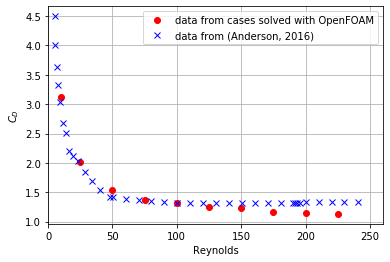

In [54]:
val.compare_forces('../data', lower_re=5, higher_re=250, xlim=(0, 260))

### Computing the Fast Fourier Transform

Now we go step-by-step in finding the Strouhal number
of a single case just to illustrate how it's done.
After that we do this automatically for all cases at once.

Based on code on the file [strouhal.py](https://github.com/Comflics/Exploring-OpenFOAM/blob/master/laminarVortexShedding/strouhal.py)
from comflics's tutorial:
+ [github](https://github.com/Comflics/Exploring-OpenFOAM)
+ [youtube](https://www.youtube.com/watch?v=ylZQXiEdYYo)
+ [blog](http://comflics.blogspot.com/2014/08/openfoam-tutorial-4-laminar-vortex-shedding.html)
+ [pdf](https://nbviewer.jupyter.org/github/Comflics/Exploring-OpenFOAM/blob/master/Exploring-OpenFOAM.pdf)


First, we load a solved case:

In [55]:
dataset = Dataset('../data')
case = dataset.get_sample(10)

We check its Reynolds:

In [56]:
case.reynolds

300

And load the lift coefficient time series:

In [57]:
lift_coeff_series = case.force_series('C_L')

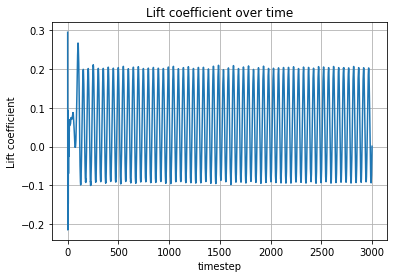

In [58]:
plt.plot(lift_coeff_series)
plt.grid('on')
plt.ylabel('Lift coefficient')
plt.xlabel('timestep')
plt.title('Lift coefficient over time')
plt.show()

We find the timestep in the series:

In [59]:
time_series = case.force_series('times')
dt = time_series[1] - time_series[0]

Now we define a very sensitive parameter, the window size used to compute the FFT:

In [60]:
window_size = 100

Now, computing the FFT:

In [61]:
freq, cl_amp = signal.welch(lift_coeff_series, 1./dt, nperseg=window_size)

Plotting the transformed signal:

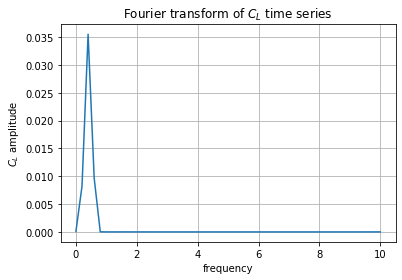

In [62]:
plt.plot(freq, cl_amp)         
plt.grid('on')
plt.ylabel('$C_L$ amplitude')
plt.xlabel('frequency')
plt.title('Fourier transform of $C_L$ time series')
plt.show() 

Finding the fundamental frequency, which is the one at which the amplitude peaks:

In [63]:
# find the array index corresponding to max amplitude
_fundamental_frequency_index = np.argmax(abs(cl_amp))  
vortex_shedding_freq = freq[_fundamental_frequency_index]
vortex_shedding_freq

0.4

The other 2 parameters needed to compute the Strouhal number:

In [64]:
speed = case.freestream_speed
ref_length = case.diameter

Finally, using everything to compute the Strouhal number:

In [65]:
strouhal = vortex_shedding_freq * ref_length / speed
strouhal

0.13333333333333333

Just to contrast, what if instead of `window_size = 100` we had different values?

In [66]:
val.compute_strouhal(case, window_size=5)

1.3333333333333333

In [67]:
val.compute_strouhal(case, window_size=50)

0.13333333333333333

In [68]:
val.compute_strouhal(case, window_size=200)

0.13333333333333333

In [69]:
val.compute_strouhal(case, window_size=2000)

0.1366666666666667

Impressively robust!

For reference, expected Strouhal number:

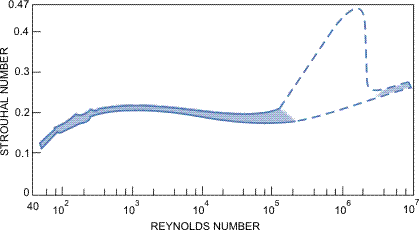

Source: http://thermopedia.com/content/1247/

### Finding all Strouhal numbers

After fiddling a bit with the `window_size` below,
it seems 400 yields fairly stable estimates of the Strouhal number.


In [70]:
strouhal_data = val.load_strouhal(dataset, window_size=400)
pd.DataFrame(strouhal_data, columns=('Reynolds', 'Strouhal'))

,Reynolds,Strouhal
0,10,100.000000
1,25,40.000000
2,50,20.000000
3,75,0.133333
4,100,0.100000
5,125,0.120000
6,150,0.133333
7,175,0.114286
8,200,0.125000
9,225,0.133333


How many of the cases to throw away:

In [74]:
throw_away = 3

In [83]:
pd.DataFrame(strouhal_data[throw_away:], columns=('Reynolds', 'Strouhal'))

,Reynolds,Strouhal
0,75,0.133333
1,100,0.100000
2,125,0.120000
3,150,0.133333
4,175,0.114286
5,200,0.125000
6,225,0.133333
7,250,0.140000
8,275,0.127273
9,300,0.133333


I contend these numbers (about 0.13 from Reynolds = 125 up to 300)
are fairly accurate in light of the image linked above.

We'll use the data below as a reference. It was extracted from (Roshko, 1954) as cited in [this link](http://www.dept.aoe.vt.edu/~jschetz/Sampler/s5.html). The points were extracted using [this tool](https://apps.automeris.io/wpd/) from the image below.

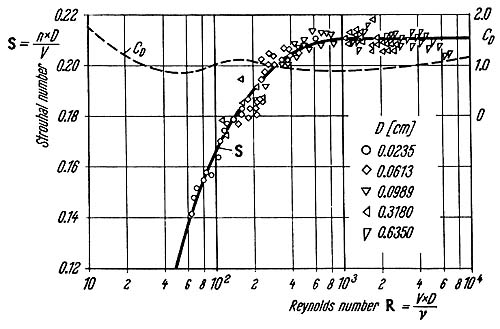

+ ROSHKO, A. 1954 On the drag and shedding frequency of two-dimensional bluff bodies. Tech. Rep.

In [72]:
reference_reynolds = [
    49.02726777678379,
    52.1848490874612,
    59.46808989490679,
    69.11516401316487,
    79.27140712651041,
    92.70549804839868,
    109.84268675507464,
    136.4036043944658,
    183.49951156480503,
    258.2674339262041,
    337.42091225574785,
    431.9979189618425,
    610.393209407566,
    844.9018257271622,
    1115.8704069384728,
]

reference_strouhal = [
    0.12167942427670253,
    0.12687717301539936,
    0.13582156464048525,
    0.1444699056885293,
    0.15312241059841636,
    0.1610441577548457,
    0.16867193626515475,
    0.17744436039612208,
    0.18735102049314006,
    0.1952144735837665,
    0.2000578776796186,
    0.20418301560754218,
    0.2071177054345337,
    0.20875451952504218,
    0.20924668799489235,
]

Finally, we plot the Strouhal numbers.
First, we define the filename to save the plot to.

In [73]:
strouhal_plot_file = 'strouhal.png'

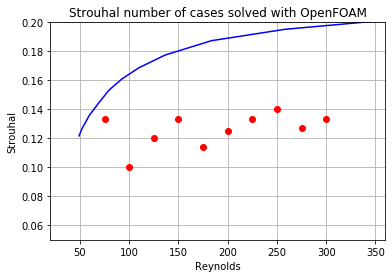

In [84]:
strouhal_numpy = np.array(strouhal_data)

rey_series = strouhal_numpy[throw_away:, 0]
str_series = strouhal_numpy[throw_away:, 1]

plt.plot(rey_series,
         str_series,
         'ro')
plt.xlabel('Reynolds')
plt.ylabel('Strouhal')
plt.title('Strouhal number of cases solved with OpenFOAM')

plt.plot(reference_reynolds, reference_strouhal, 'b-')

plt.xlim(20, 360)
plt.ylim(.05, .20)

plt.grid()
plt.savefig(strouhal_plot_file)
plt.show()